In [1]:
import numpy as np
import pandas as pd
from functions import *
from schemes import *
from plot import * 
from Kepler import *

%matplotlib inline

In [2]:
def evolution(scheme, r0s, v0s, T, h, e, G, masses):
    m1 = masses[0]
    m2 = masses[1]
    mu = G * (m1 + m2) 
    
    # reposition centre of mass to origin with no momentum 
    rcom, vcom = CentreOfMass(r0s, v0s, masses)
    r0sprime = r0s - rcom
    v0sprime = v0s - vcom

    traj = run_scheme(scheme, 0, T, h, r0sprime, v0sprime, G, masses)
    
    a = SemiMajorAxis(mu, r0s, v0s)
    
    t_traj = np.array(traj[0]) 
    rs_traj_central = np.copy(traj[1])

    kepler_traj = KeplerOrbit(a, e, mu, t_traj)
    
    rs_traj_central = Centralise(rs_traj_central, 0) 

    errs = kepler_traj - rs_traj_central[:,1,:]
    errs = np.linalg.norm(errs, axis = 1)

    return errs, traj

In [3]:
# gravity
G = 1

# mass ratio & eccentricity 
q = 1.0 # q = m2 / m1
e = 0.0

m1 = 1 # central mass
m2 = q # orbiting mass
mu = G * (m1 + m2) 

# position
r1 = np.array([0,0.0,0.0], dtype="float64")
r2 = np.array([1,0.0,0.0], dtype="float64")

# velocity 
v1 = np.array([0,0.0,0], dtype="float64")
v2 = np.array([0,np.sqrt((1 + q)*(1 + e)),0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2])
v0s = np.array([v1,v2])
masses = np.array([m1, m2])

#### h = 0.01, T = 100

In [4]:
h = 0.01
T = 100
trajectories = []
errs = []
schemes = ['Explicit Euler', 'Symplectic Euler', 'Leapfrog', 'RK4', 'Forest-Ruth', 'Scipy']

In [5]:
Euler_errs, Euler_traj = evolution(EulerStep, r0s, v0s, T, h, e, G, masses)
trajectories.append(Euler_traj)
errs.append(Euler_errs)

In [6]:
EulerCromer_errs, EulerCromer_traj = evolution(EulerCromerStep, r0s, v0s, T, h, e, G, masses)
trajectories.append(EulerCromer_traj)
errs.append(EulerCromer_errs)

In [7]:
Leapfrog_errs, Leapfrog_traj = evolution(LeapfrogStep, r0s, v0s, T, h, e, G, masses)
trajectories.append(Leapfrog_traj)
errs.append(Leapfrog_errs)

In [8]:
RK4_errs, RK4_traj = evolution(RK4Step, r0s, v0s, T, h, e, G, masses)
trajectories.append(RK4_traj)
errs.append(RK4_errs)

In [9]:
ForestRuth_errs, ForestRuth_traj = evolution(PEFRLStep, r0s, v0s, T, h, e, G, masses)
trajectories.append(ForestRuth_traj)
errs.append(ForestRuth_errs)

In [10]:
Scipy_traj = run_scipy(0, T, h, r0s, v0s, G, masses)
    
a = SemiMajorAxis(mu, r0s, v0s)
    
t_traj = np.array(Scipy_traj[0]) 
rs_traj_Scipy = np.copy(Scipy_traj[1])

kepler_traj = KeplerOrbit(a, e, mu, t_traj)
    
rs_traj_central = Centralise(rs_traj_Scipy, 0) 

Scipy_error = kepler_traj - rs_traj_central[:,1,:]
Scipy_error = np.linalg.norm(Scipy_error, axis = 1)
trajectories.append(Scipy_traj)
errs.append(Scipy_error)

In [11]:
def PlotOrbits2(trajectories, schemeName, T, h, masses):
    t_traj, rs_traj, vs_traj, E_traj, am_traj, time = trajectories
    N = rs_traj.shape[1] # number of masses in the system

    colours = plt.cm.rainbow(np.linspace(0,1,N)) # colour according to how many masses
    
    plt.style.use('default')

    fig, ax = plt.subplots(1, 1, figsize=(7,7))

    # loop over all masses 
    for i in range(N):
        color = colours[i]
        ri_traj = rs_traj[:,i,:] # get the i-th trajectory
        vi_traj = vs_traj[:,i,:]
        ax.plot(ri_traj[:,0], ri_traj[:,1],  zorder = 1, label=f'mass {i+1}', color=color)
        # ax.scatter(ri_traj[:,0], ri_traj[:,1],  zorder = 1, label=f'mass {i+1}', color=color, marker = 'x') # plot the orbits
        ax.scatter(ri_traj[0,0],ri_traj[0,1],marker="o", facecolor = 'white',s=50, zorder = 2, color=color) # plot the start positions
        ax.scatter(ri_traj[-1,0],ri_traj[-1,1],marker="o",s=50, zorder = 2, color=color) # plot the start positions

    # find and plot the centre of mass
    # rcoms = []
    # for i in range(rs_traj.shape[0]):
    #     rcom, vcom = CentreOfMass(rs_traj[i], vs_traj[i], masses)
    #     rcoms = rcoms + [rcom]
    # rcoms = np.array(rcoms)
    # ax.scatter(rcoms[:,0], rcoms[:,1], color = 'black', label = 'Centre of mass', marker = 'x', zorder = 3)

    ax.set_aspect(aspect = 'equal')
    # ax.text(0.05, 0.95, f'T = {T}, h = {h}, time = {np.round(time, 5)}', transform=ax.transAxes, 
    #        va='top', fontsize = 15)
    ax.set_xlabel('x-coordinate', fontsize = 20)
    ax.set_ylabel('y-coordinate', fontsize = 20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.yaxis.get_offset_text().set_fontsize(15)
    ax.legend(loc = 'upper right', fontsize = 20)

    plt.tight_layout()

In [12]:
def PlotEnergy2(trajectories):
    t_traj, rs_traj, vs_traj, E_traj, am_traj, time = trajectories

    ### ENERGY ###
    
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    
    relative_e_traj = RelativeEnergy(E_traj) 
    
    ax.plot(t_traj, relative_e_traj, label = 'Total Energy')
    
    ax.set_xlabel('Time', fontsize = 20)
    ax.set_ylabel('Relative Energy Error (%)', fontsize = 20)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    ax.yaxis.get_offset_text().set_fontsize(15)

    plt.tight_layout()


def PlotAngularMomentum2(trajectories):
    t_traj, rs_traj, vs_traj, E_traj, am_traj, time = trajectories

    ### ANGULAR MOMENTUM ###
    
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    
    relative_am_traj = RelativeAngMomentum(am_traj[:,-1]) 
    
    ax.plot(t_traj, relative_am_traj)
    
    ax.set_xlabel('Time', fontsize = 20)
    ax.set_ylabel('Relative Angular Momentum Error (%)', fontsize = 20)

    ax.yaxis.get_offset_text().set_fontsize(15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()

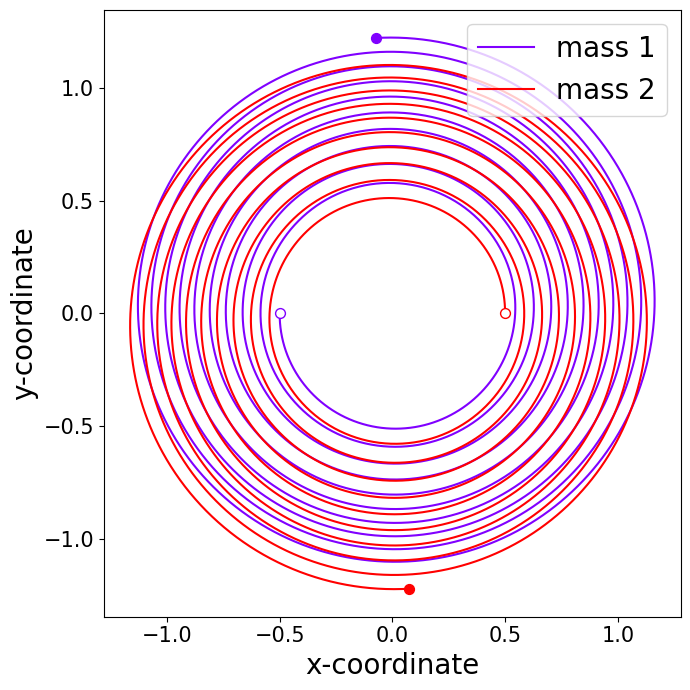

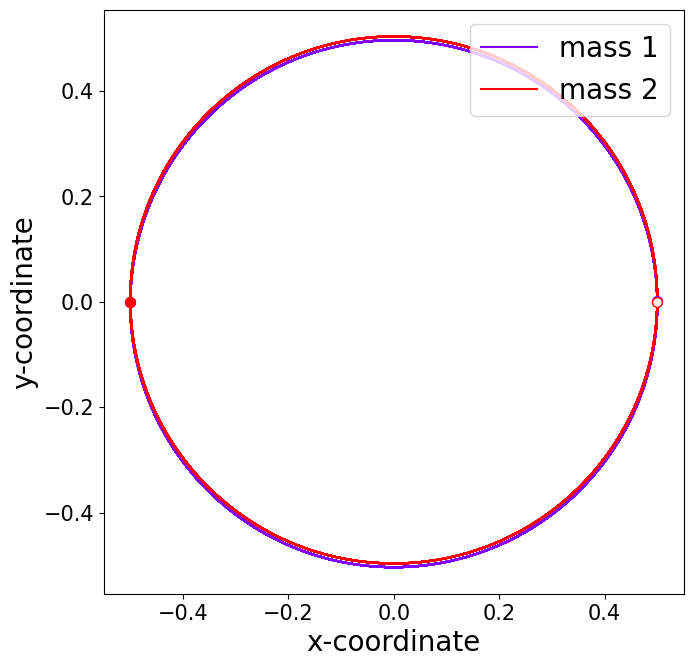

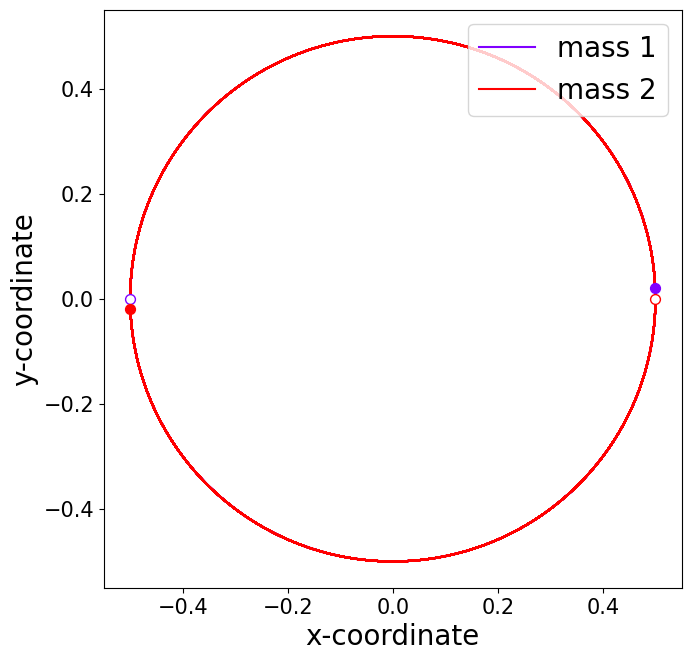

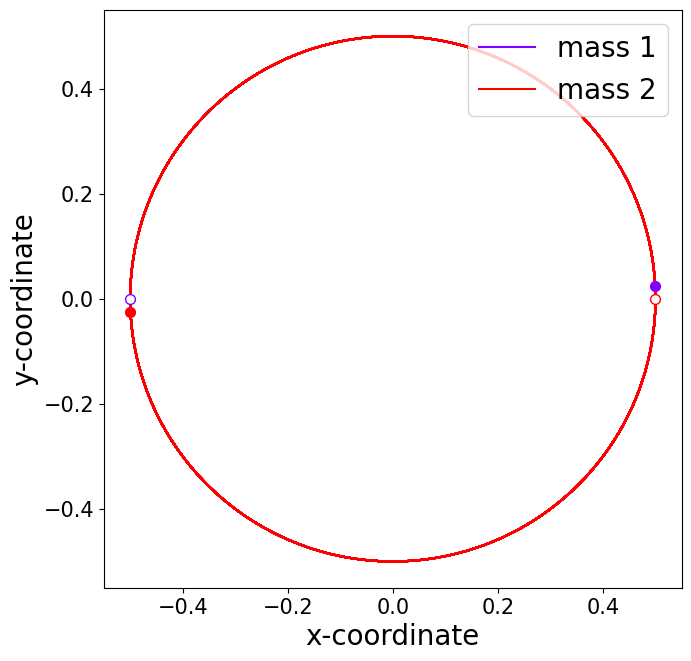

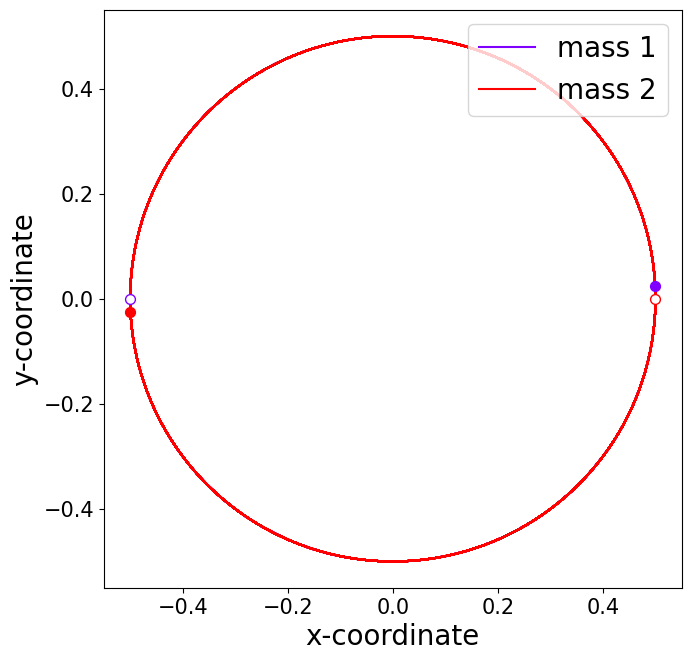

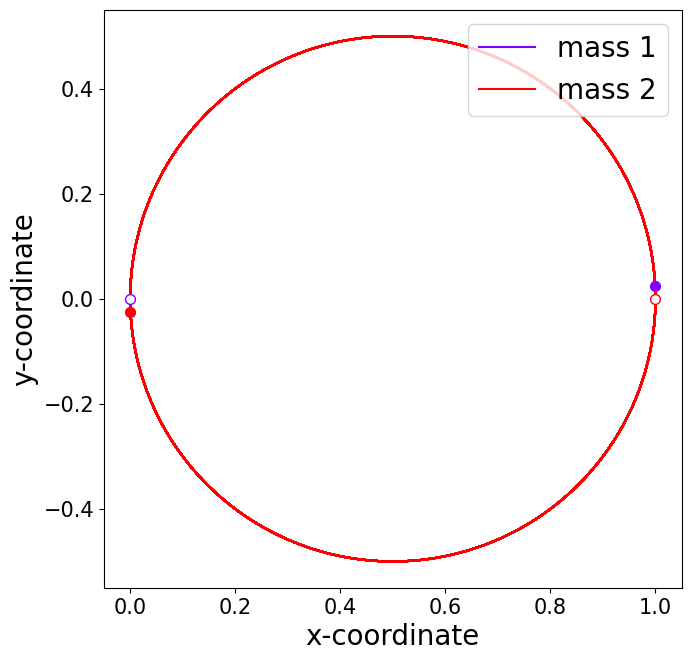

In [13]:
PlotOrbits2(Euler_traj, 'Explicit Euler', T, h, masses)
plt.savefig(f'Plots/Trajectories/Explicit Euler Traj, e = {e}.pdf', format = 'pdf')

PlotOrbits2(EulerCromer_traj, 'Symplectic Euler', T, h, masses)
plt.savefig(f'Plots/Trajectories/Symplectic Euler Traj, e = {e}.pdf', format = 'pdf')

PlotOrbits2(Leapfrog_traj, 'Leapfrog', T, h, masses)
plt.savefig(f'Plots/Trajectories/Leapfrog Euler Traj, e = {e}.pdf', format = 'pdf')

PlotOrbits2(RK4_traj, 'RK4', T, h, masses)
plt.savefig(f'Plots/Trajectories/RK4 Euler Traj, e = {e}.pdf', format = 'pdf')

PlotOrbits2(ForestRuth_traj, 'Forest-Ruth', T, h, masses)
plt.savefig(f'Plots/Trajectories/Forest-Ruth Traj, e = {e}.pdf', format = 'pdf')

PlotOrbits2(Scipy_traj, 'Scipy', T, h, masses)
plt.savefig(f'Plots/Trajectories/Scipy Traj, e = {e}.pdf', format = 'pdf')

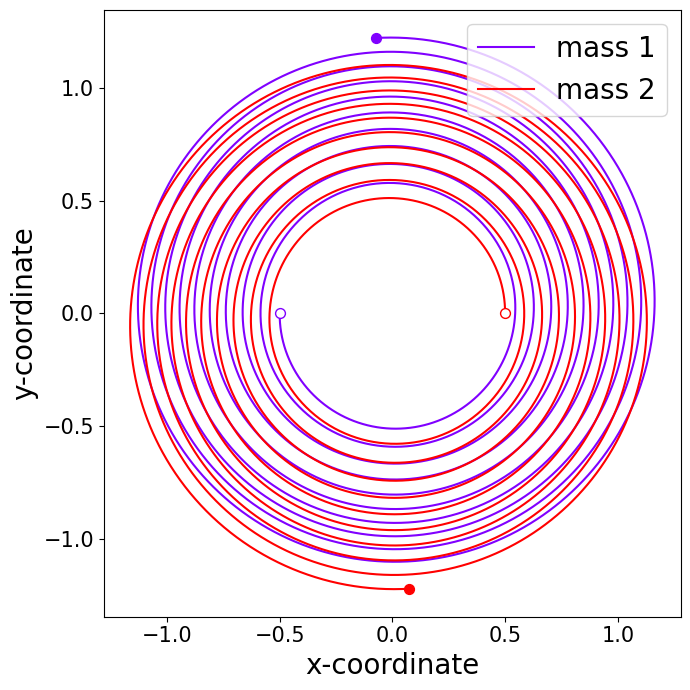

In [14]:
PlotOrbits2(Euler_traj, 'Explicit Euler', T, h, masses)
# plt.savefig(f'Plots/Trajectories/Explicit Euler Traj, e = {e}.pdf', format = 'pdf')

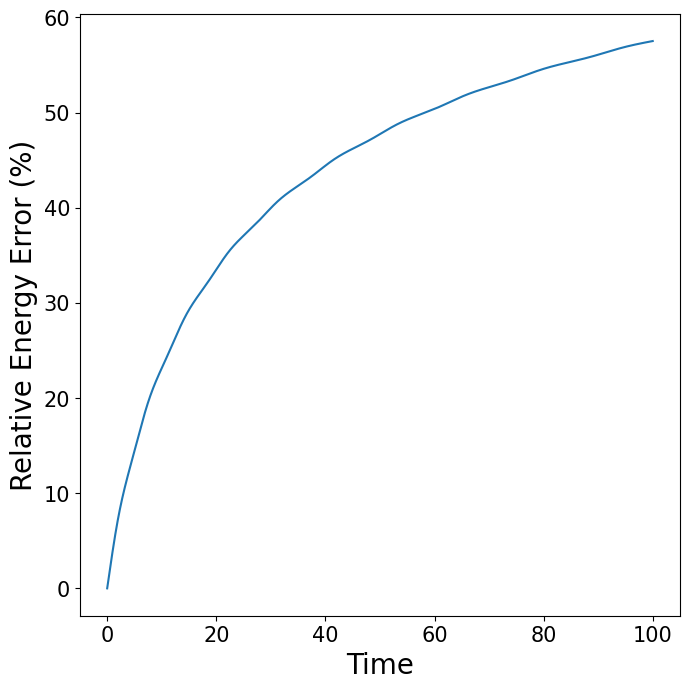

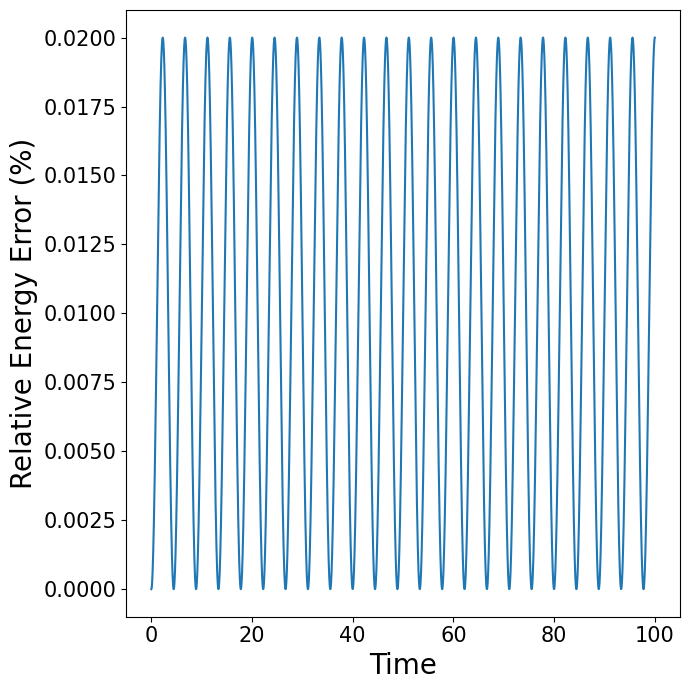

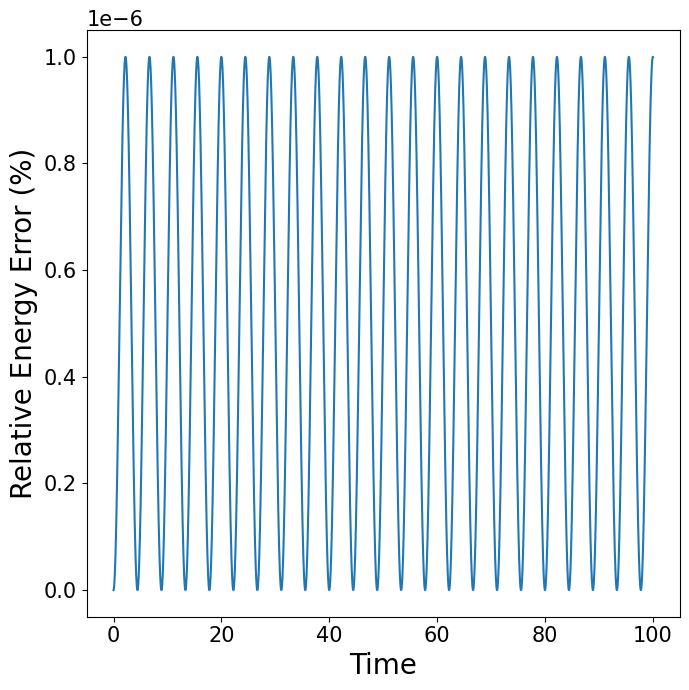

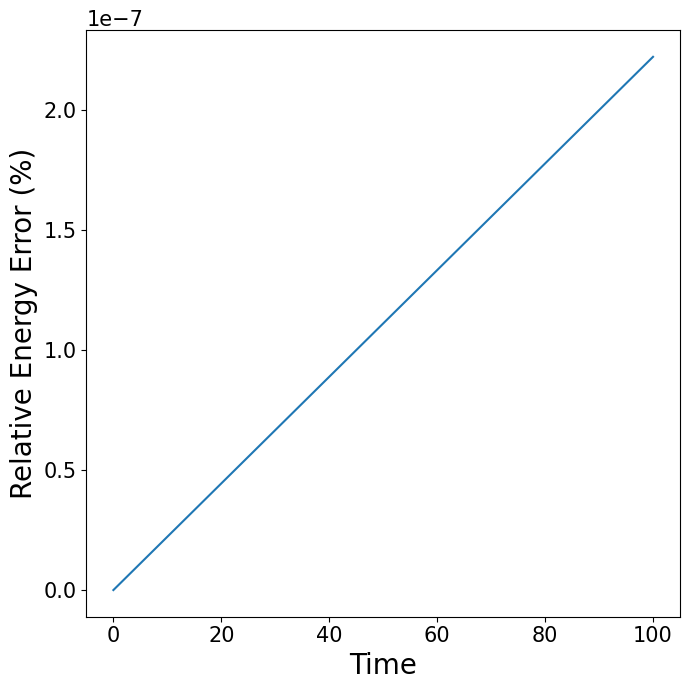

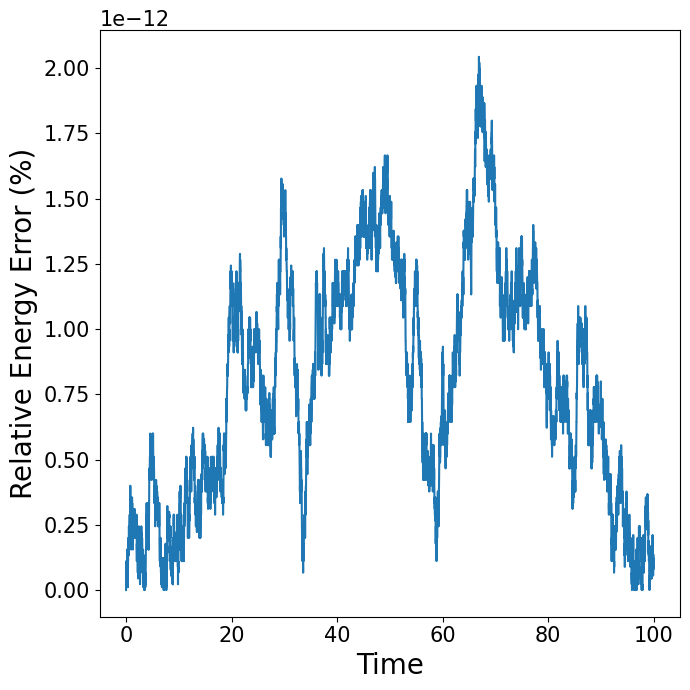

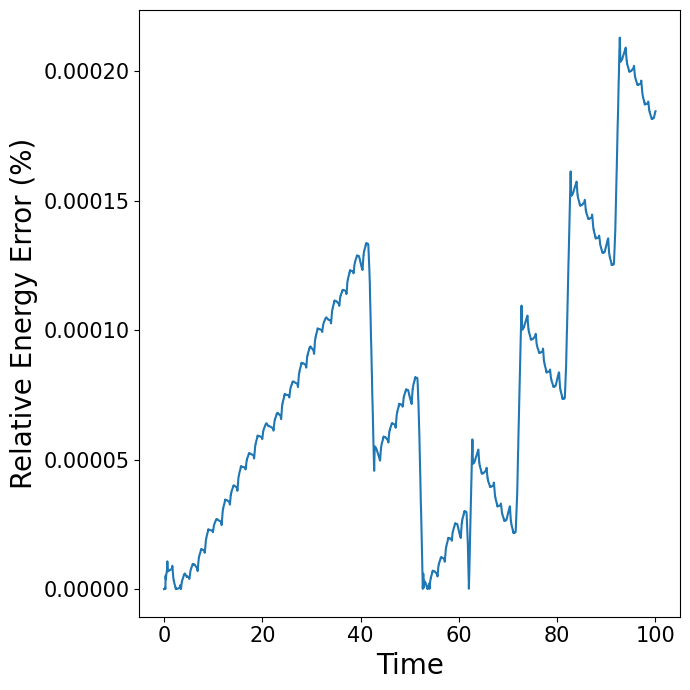

In [15]:
for i, scheme in enumerate(schemes):
    traj = trajectories[i]
    PlotEnergy2(traj)
    plt.savefig(f'Plots/Energy/{scheme} Energy, e = {e}.pdf', format = 'pdf')

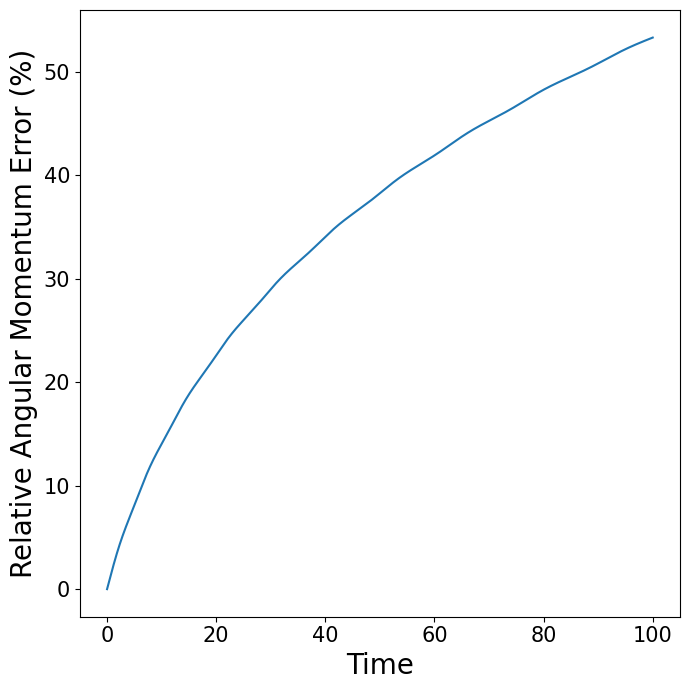

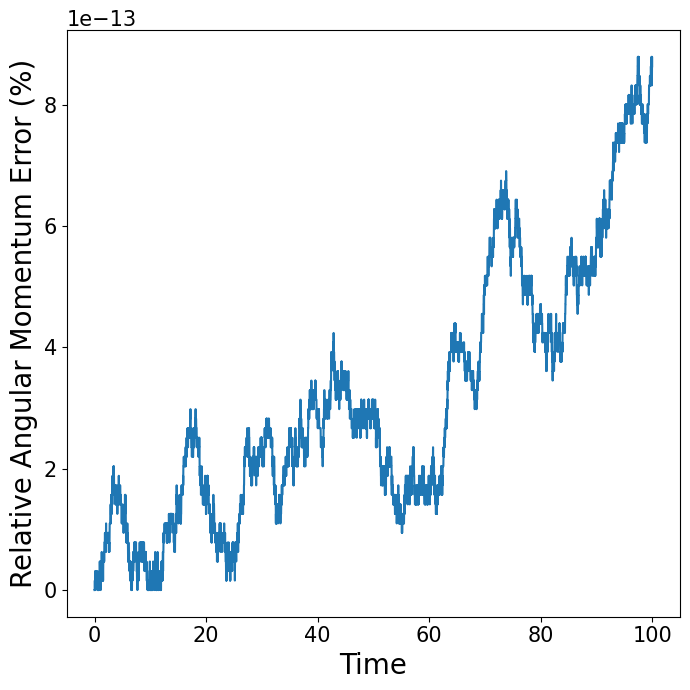

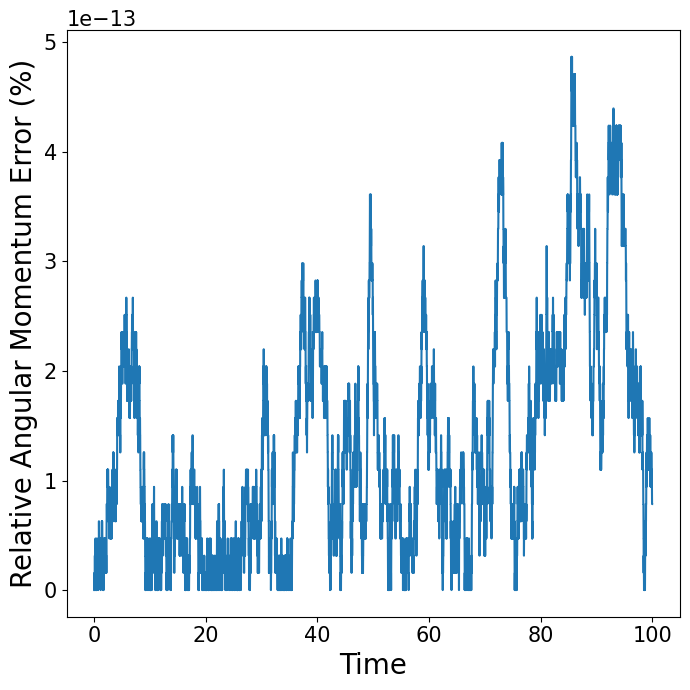

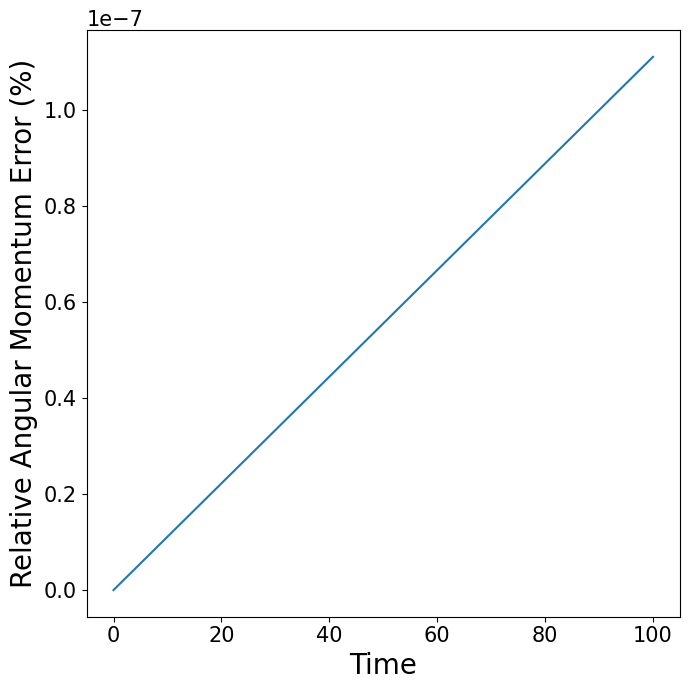

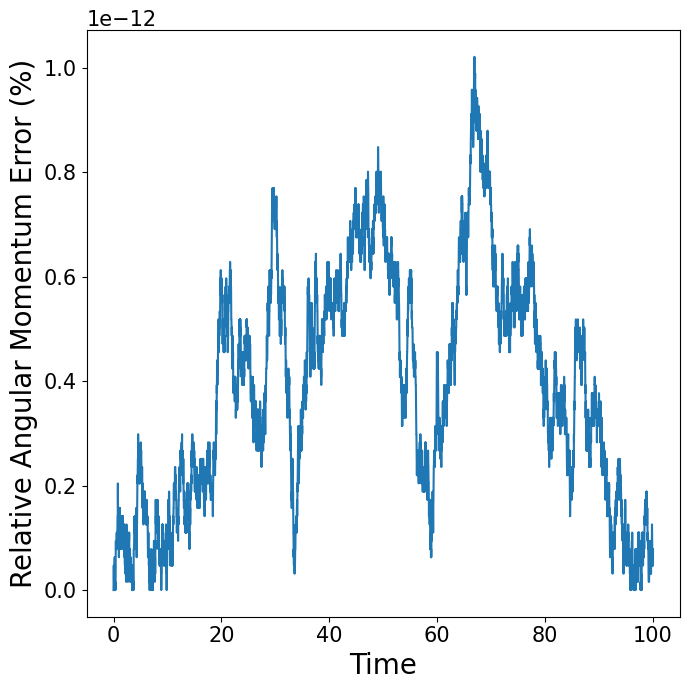

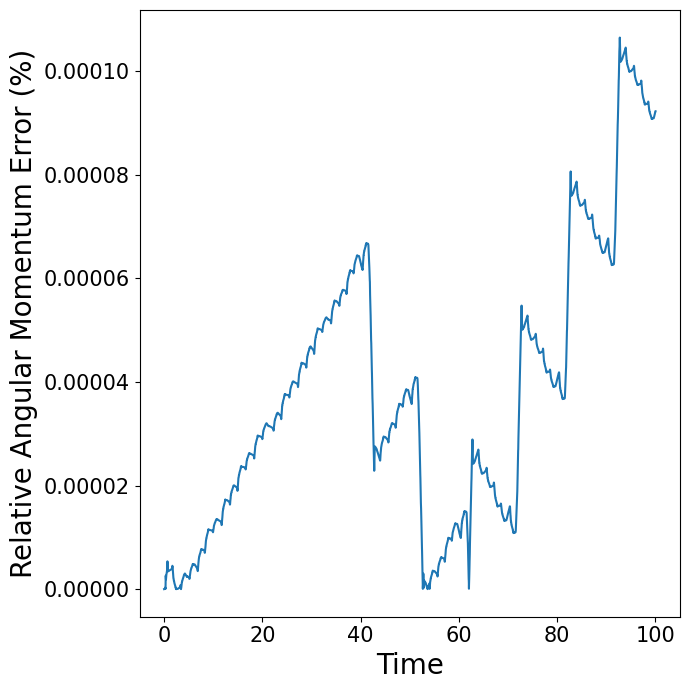

In [16]:
for i, scheme in enumerate(schemes):
    traj = trajectories[i]
    PlotAngularMomentum2(traj)
    plt.savefig(f'Plots/AM/{scheme} AM, e = {e}.pdf', format = 'pdf')

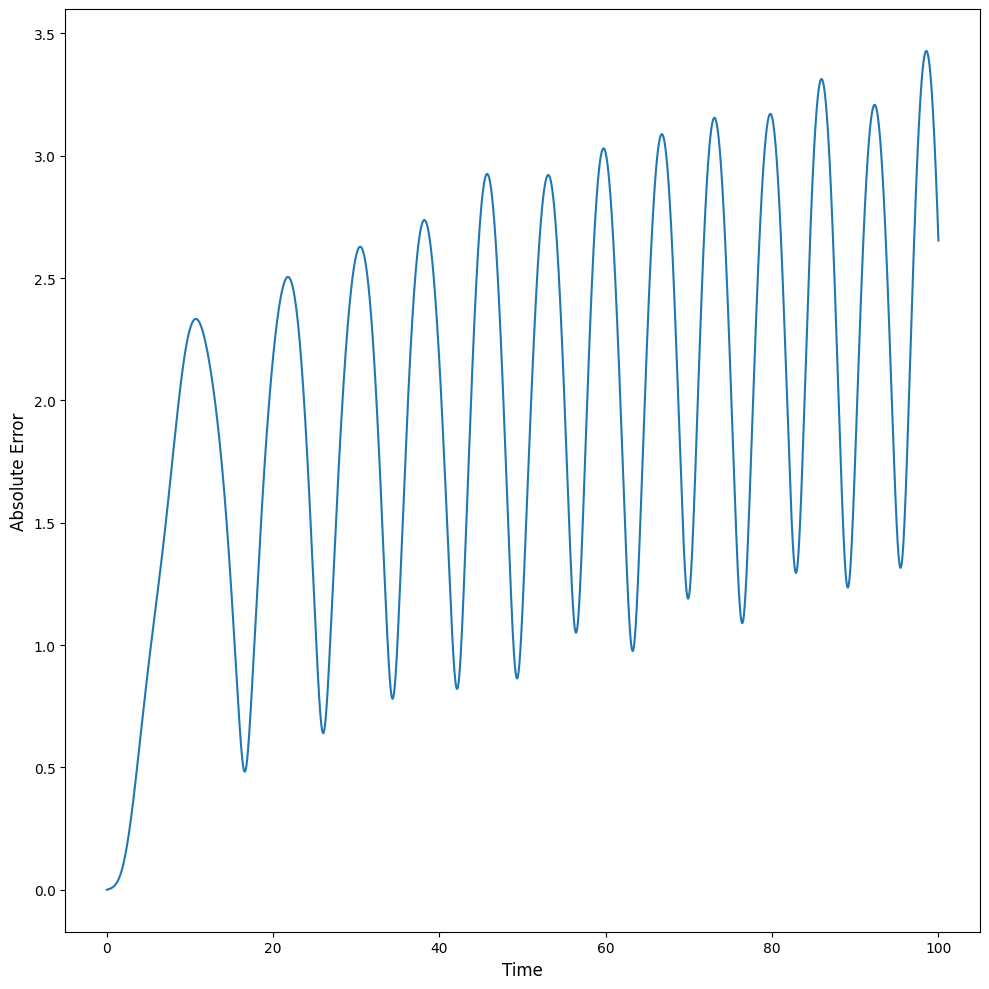

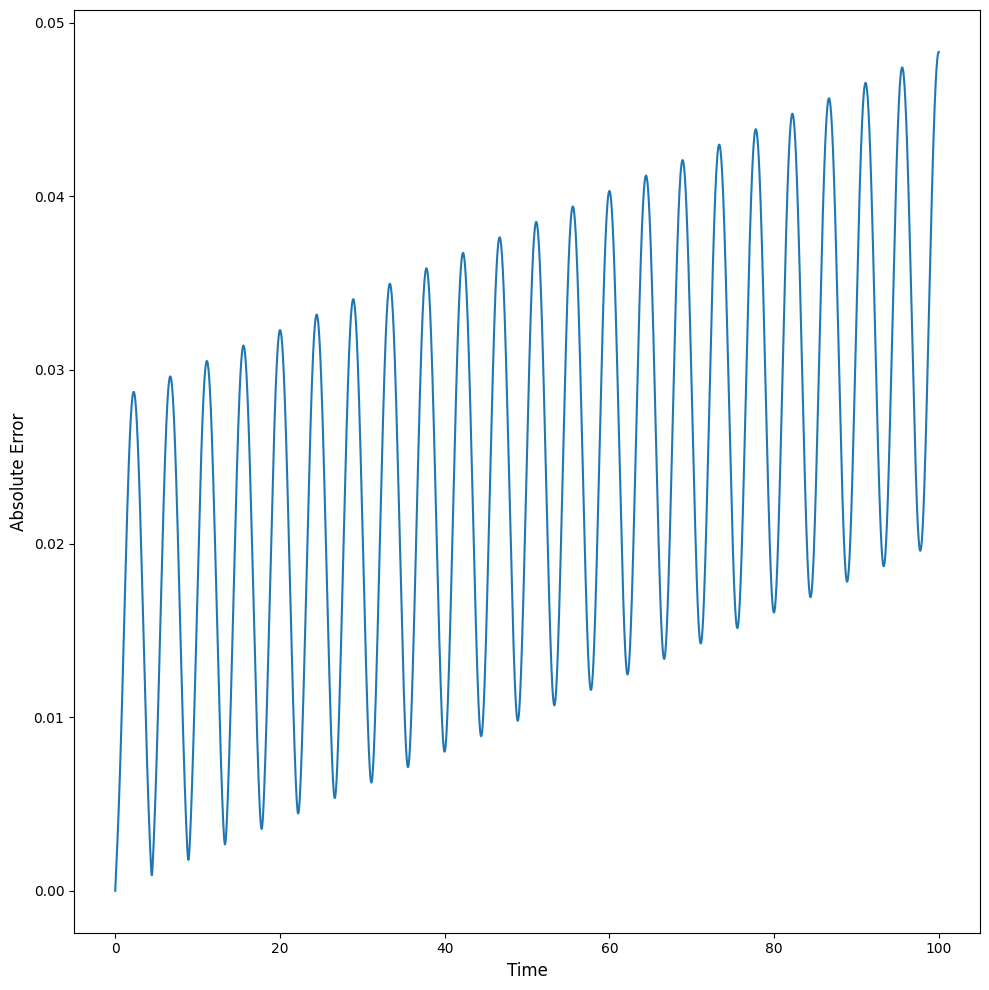

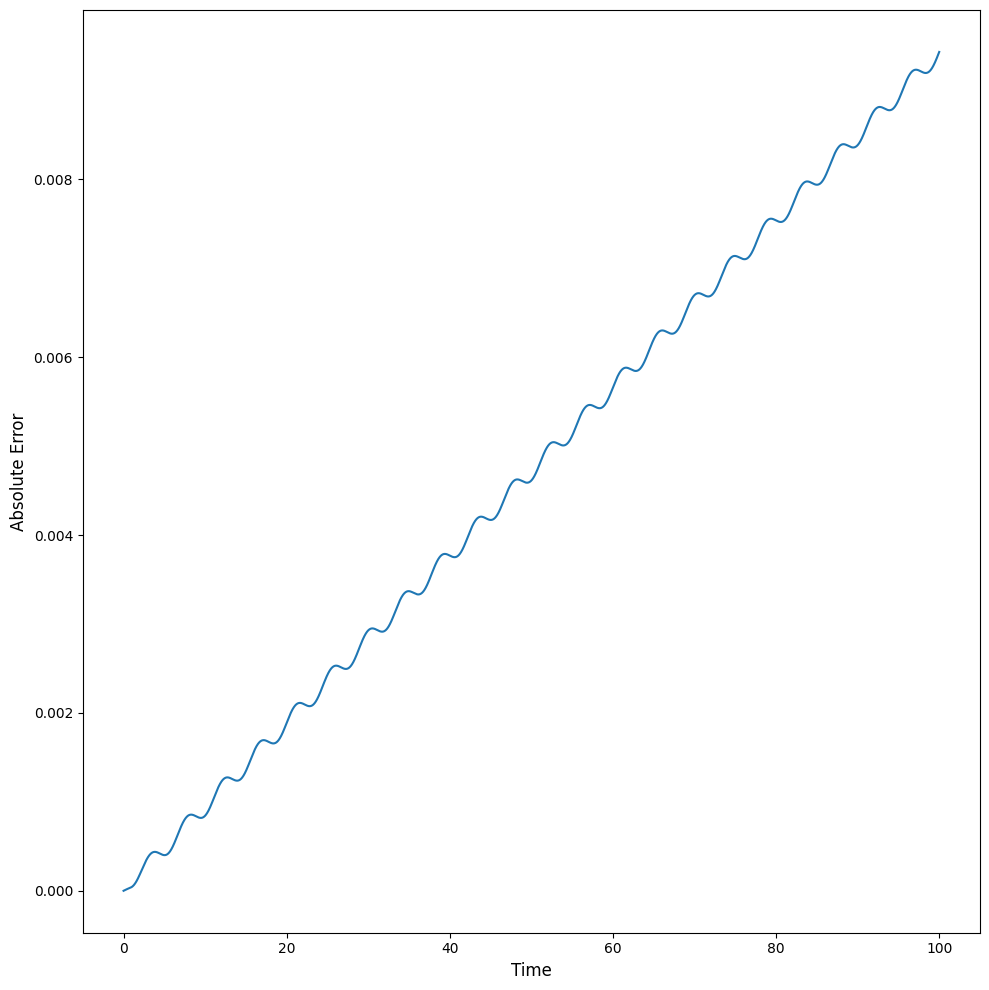

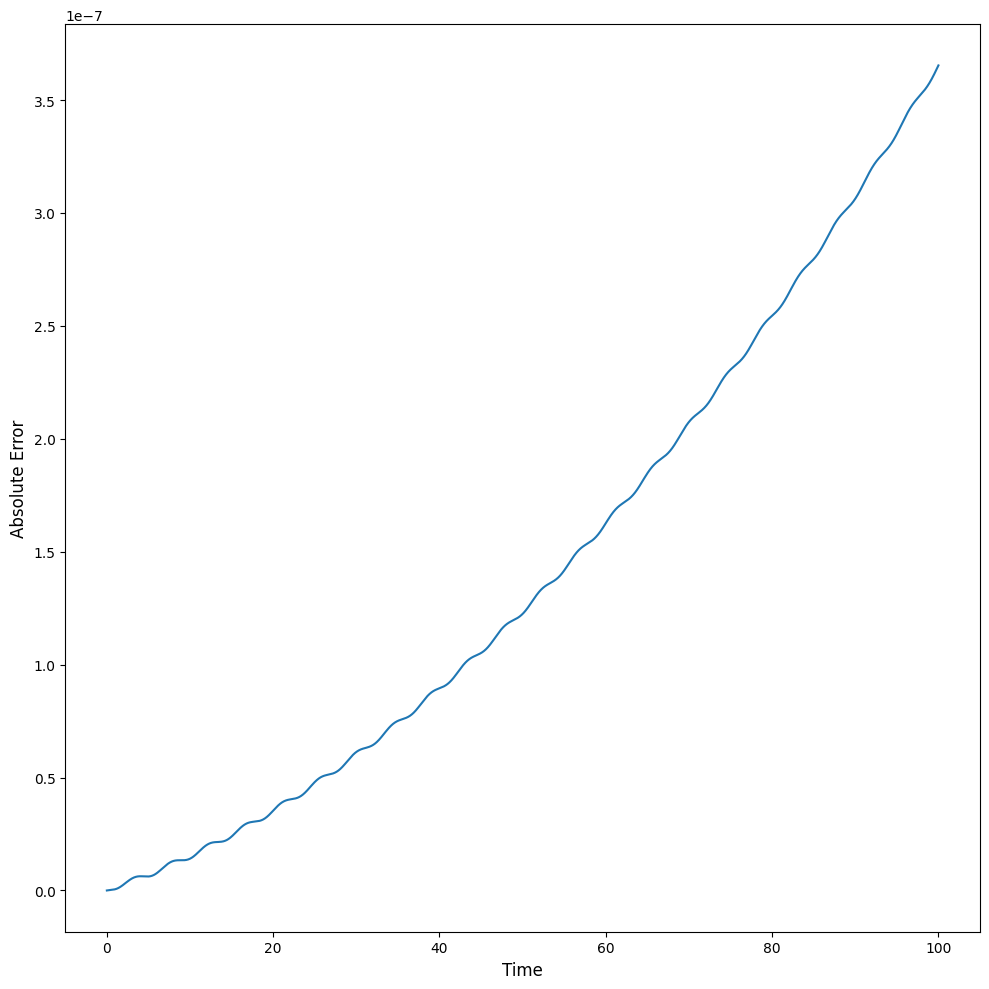

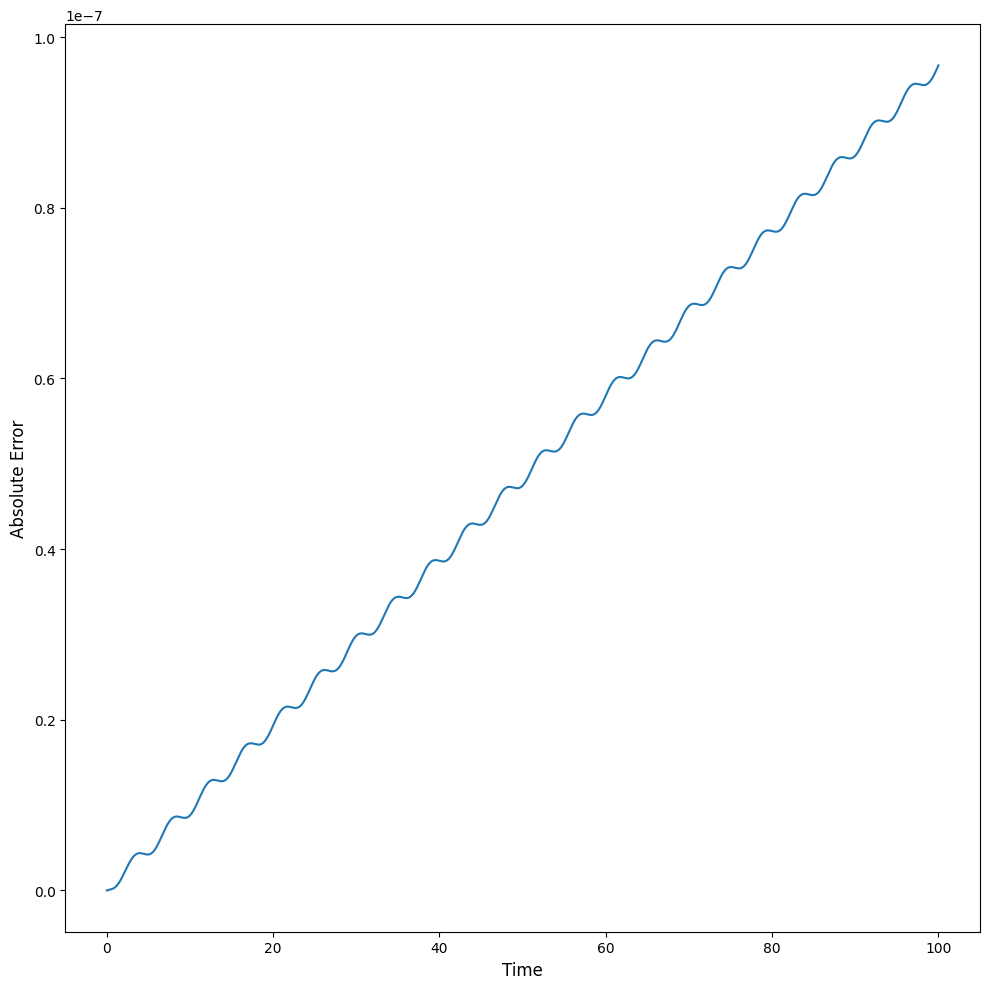

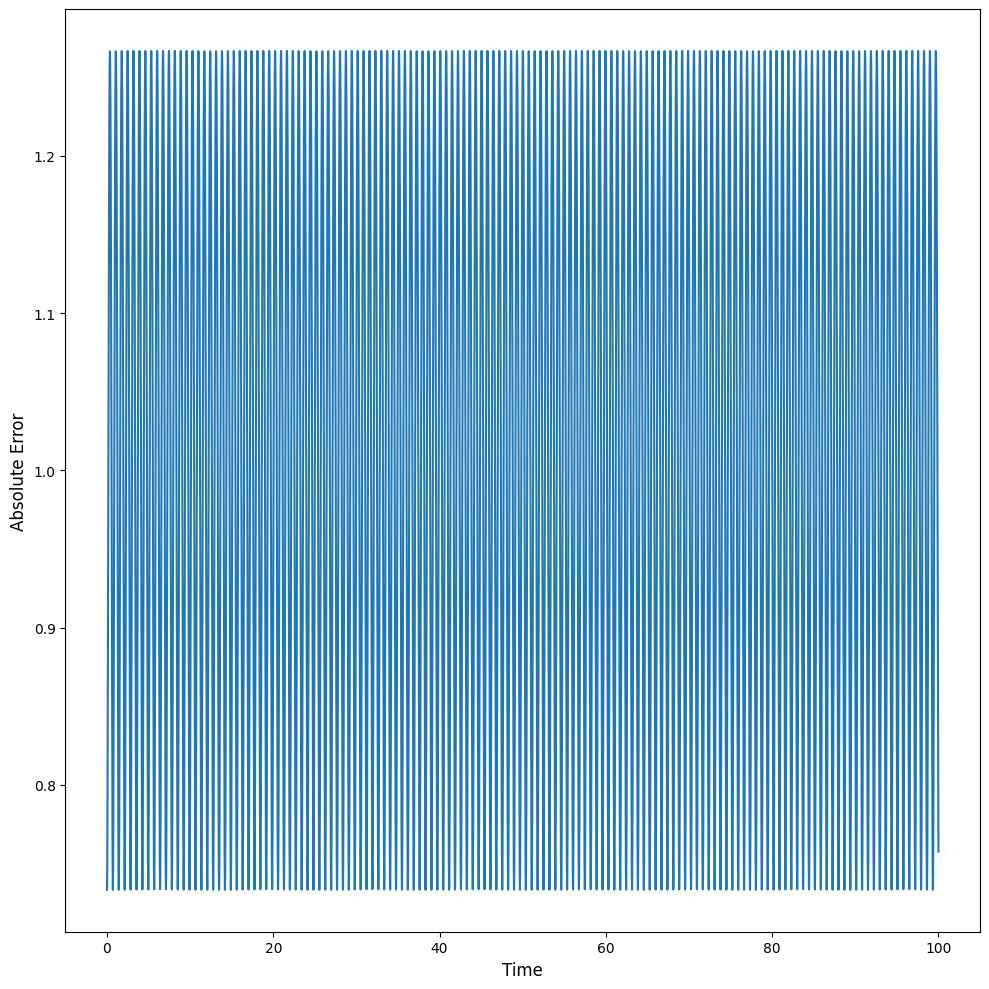

In [17]:
for i, scheme in enumerate(schemes):
    err = errs[i]
    traj = trajectories[i]
    PlotError(err, traj)
    plt.savefig(f'Plots/Error/{scheme} Error, e = {e}.pdf', format = 'pdf')

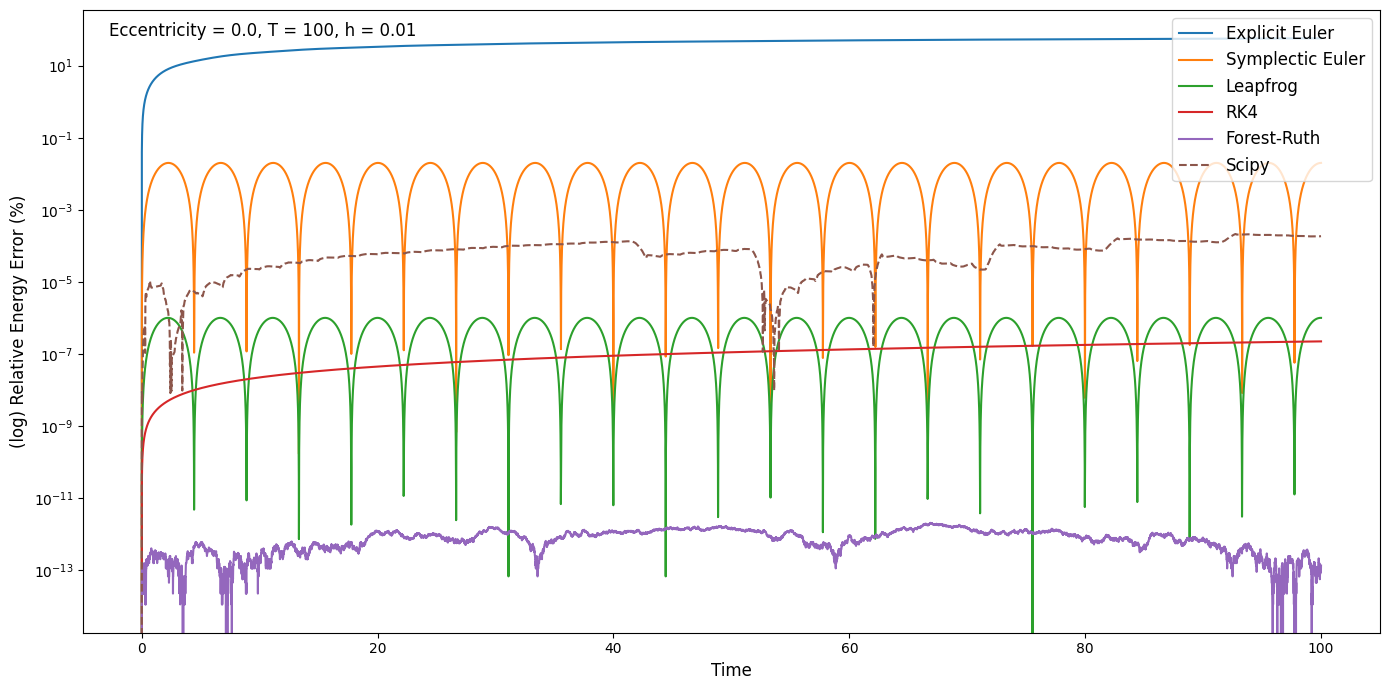

In [18]:
linestyles = ['solid', 'solid', 'solid', 'solid', 'solid', '--']

plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize = (14,7))
for i, scheme in enumerate(schemes):
    traj = trajectories[i]
    t_traj, rs_traj, vs_traj, E_traj, am_traj, time = traj
    E_traj = RelativeEnergy(E_traj)
    ax.plot(t_traj, E_traj, label = schemes[i], linestyle = linestyles[i])

ax.text(0.02, 0.98, f'Eccentricity = {e}, T = {T}, h = {h}', transform=ax.transAxes, 
            va='top', fontsize = 12)
    
ax.set_yscale('log')
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('(log) Relative Energy Error (%)', fontsize = 12)
plt.legend(loc = 'upper right', fontsize=12)
plt.tight_layout()

plt.savefig(f'Plots/Energy/Energy Comparison, eccentricity = {e}.pdf', format = 'pdf')
    

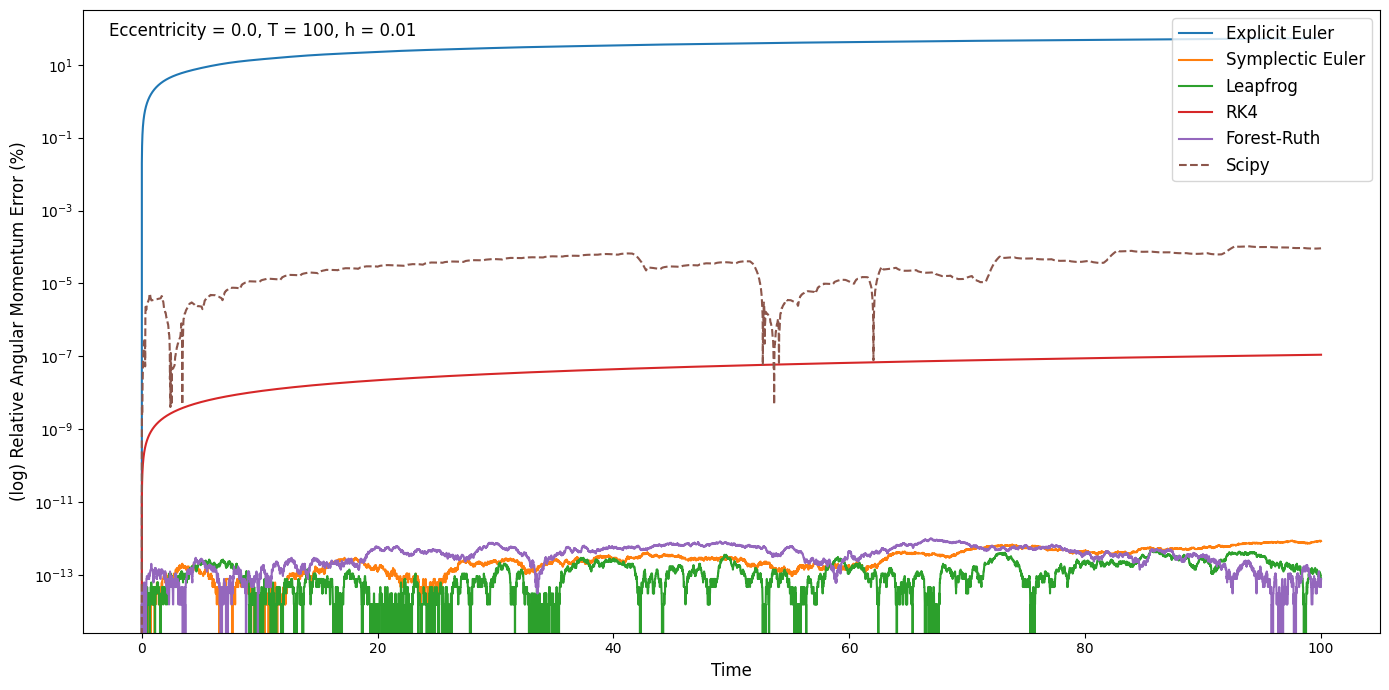

In [19]:
fig, ax = plt.subplots(1,1, figsize = (14,7))
for i, scheme in enumerate(schemes):
    traj = trajectories[i]
    t_traj, rs_traj, vs_traj, E_traj, am_traj, time = traj
    am_traj = RelativeAngMomentum(am_traj[:,0])
    ax.plot(t_traj, am_traj, label = schemes[i], linestyle = linestyles[i])

ax.text(0.02, 0.98, f'Eccentricity = {e}, T = {T}, h = {h}', transform=ax.transAxes, 
            va='top', fontsize = 12)
    
ax.set_yscale('log')
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('(log) Relative Angular Momentum Error (%)', fontsize = 12)
plt.legend(loc = 'upper right', fontsize=12)
plt.tight_layout()
plt.savefig(f'Plots/AM/AM Comparison, eccentricity = {e}.pdf', format = 'pdf')
    

(10000,) (10000,)
(10000,) (10000,)
(10000,) (10000,)
(10000,) (10000,)
(10000,) (10000,)


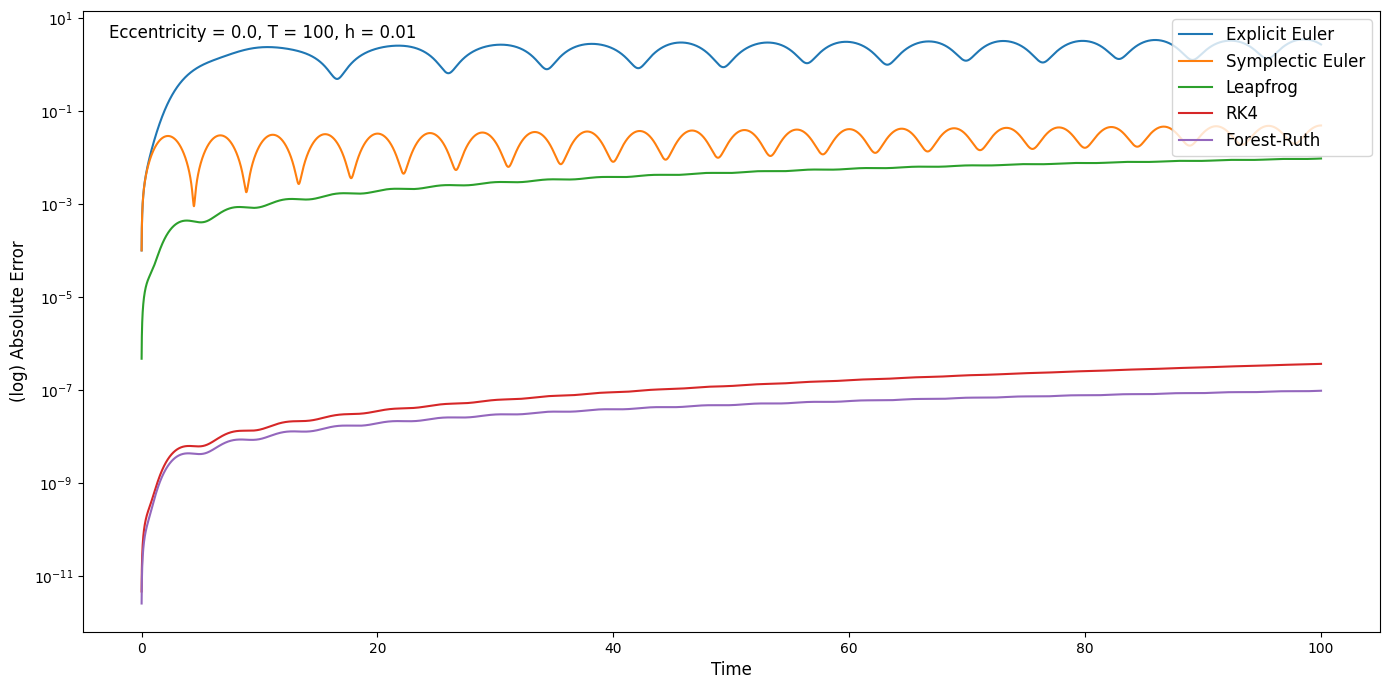

In [20]:
fig, ax = plt.subplots(1,1, figsize = (14,7))
for i, scheme in enumerate(schemes[:-1]):
    err = errs[i][1:]
    print(t_traj.shape, err.shape)
    ax.plot(t_traj, err, label = schemes[i], linestyle = linestyles[i])

ax.text(0.02, 0.98, f'Eccentricity = {e}, T = {T}, h = {h}', transform=ax.transAxes, 
            va='top', fontsize = 12)
    
ax.set_yscale('log')
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('(log) Absolute Error', fontsize = 12)
plt.legend(loc = 'upper right', fontsize=12)
plt.tight_layout()
plt.savefig(f'Plots/Error/Error Comparison, eccentricity = {e}.pdf', format = 'pdf')